# Fraud Detection - Complete EDA and Preprocessing
## Task 1: Data Analysis and Preprocessing

This notebook implements all Task 1 requirements:
- Data cleaning with missing value handling
- Comprehensive EDA (univariate and bivariate analysis)
- Geolocation integration
- Feature engineering
- Data transformation
- Class imbalance handling with SMOTE

In [1]:
# Install required packages
import sys
import subprocess
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imbalanced-learn'])
    print('✓ Package installed!')
except:
    print('Package already installed')

✓ Package installed!


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths
DATA_DIR = '../data/raw'
FRAUD_DATA_PATH = f'{DATA_DIR}/Fraud_Data.csv'
IP_COUNTRY_PATH = f'{DATA_DIR}/IpAddress_to_Country.csv'
PROCESSED_DIR = '../data/processed'

print('Libraries imported successfully!')

Libraries imported successfully!


## 1. Data Loading and Initial Inspection

In [3]:
# Load data
fraud_df = pd.read_csv(FRAUD_DATA_PATH)
ip_country_df = pd.read_csv(IP_COUNTRY_PATH)

print('Dataset loaded successfully!')
print(f'Fraud Data Shape: {fraud_df.shape}')
print(f'IP-Country Data Shape: {ip_country_df.shape}')
print('\nFirst few rows:')
fraud_df.head()

Dataset loaded successfully!
Fraud Data Shape: (151112, 11)
IP-Country Data Shape: (138846, 3)

First few rows:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


## 2. Data Cleaning
### 2.1 Missing Values Analysis

In [4]:
# Check for missing values
print('Missing Values Analysis:')
print('='*50)
missing = fraud_df.isnull().sum()
missing_pct = (missing / len(fraud_df)) * 100
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0])

if missing.sum() == 0:
    print('\n✓ No missing values found!')
else:
    print(f'\n⚠ Total missing values: {missing.sum()}')
    print('Strategy: Drop rows with missing values (if <1%) or impute (if >1%)')

Missing Values Analysis:
Empty DataFrame
Columns: [Count, Percentage]
Index: []

✓ No missing values found!


### 2.2 Remove Duplicates and Correct Data Types

In [5]:
# Remove duplicates
initial_rows = len(fraud_df)
fraud_df.drop_duplicates(inplace=True)
duplicates_removed = initial_rows - len(fraud_df)
print(f'Duplicates removed: {duplicates_removed}')

# Correct data types
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

print('\nData types after correction:')
print(fraud_df.dtypes)
print(f'\n✓ Final shape: {fraud_df.shape}')

Duplicates removed: 0

Data types after correction:
user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

✓ Final shape: (151112, 11)


## 3. Exploratory Data Analysis (EDA)
### 3.1 Class Distribution Analysis

Class Distribution:
Non-Fraud (0): 136,961 (90.64%)
Fraud (1): 14,151 (9.36%)

Imbalance Ratio: 9.678539:1


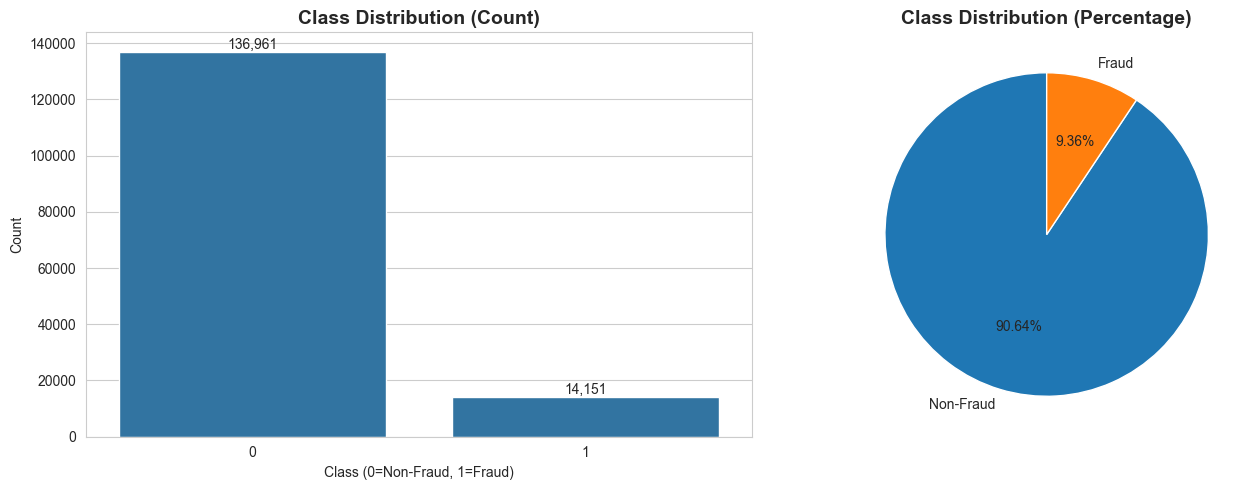


⚠ Highly imbalanced dataset - SMOTE will be required!


In [6]:
# Class distribution
class_dist = fraud_df['class'].value_counts()
class_pct = fraud_df['class'].value_counts(normalize=True) * 100

print('Class Distribution:')
print('='*50)
print(f'Non-Fraud (0): {class_dist[0]:,} ({class_pct[0]:.2f}%)')
print(f'Fraud (1): {class_dist[1]:,} ({class_pct[1]:.2f}%)')
print(f'\nImbalance Ratio: {class_dist[0]/class_dist[1]:1f}:1')

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=fraud_df, x='class', ax=ax1)
ax1.set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
ax1.set_ylabel('Count')
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

# Pie chart
ax2.pie(class_dist, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print('\n⚠ Highly imbalanced dataset - SMOTE will be required!')

### 3.2 Univariate Analysis - Numerical Features

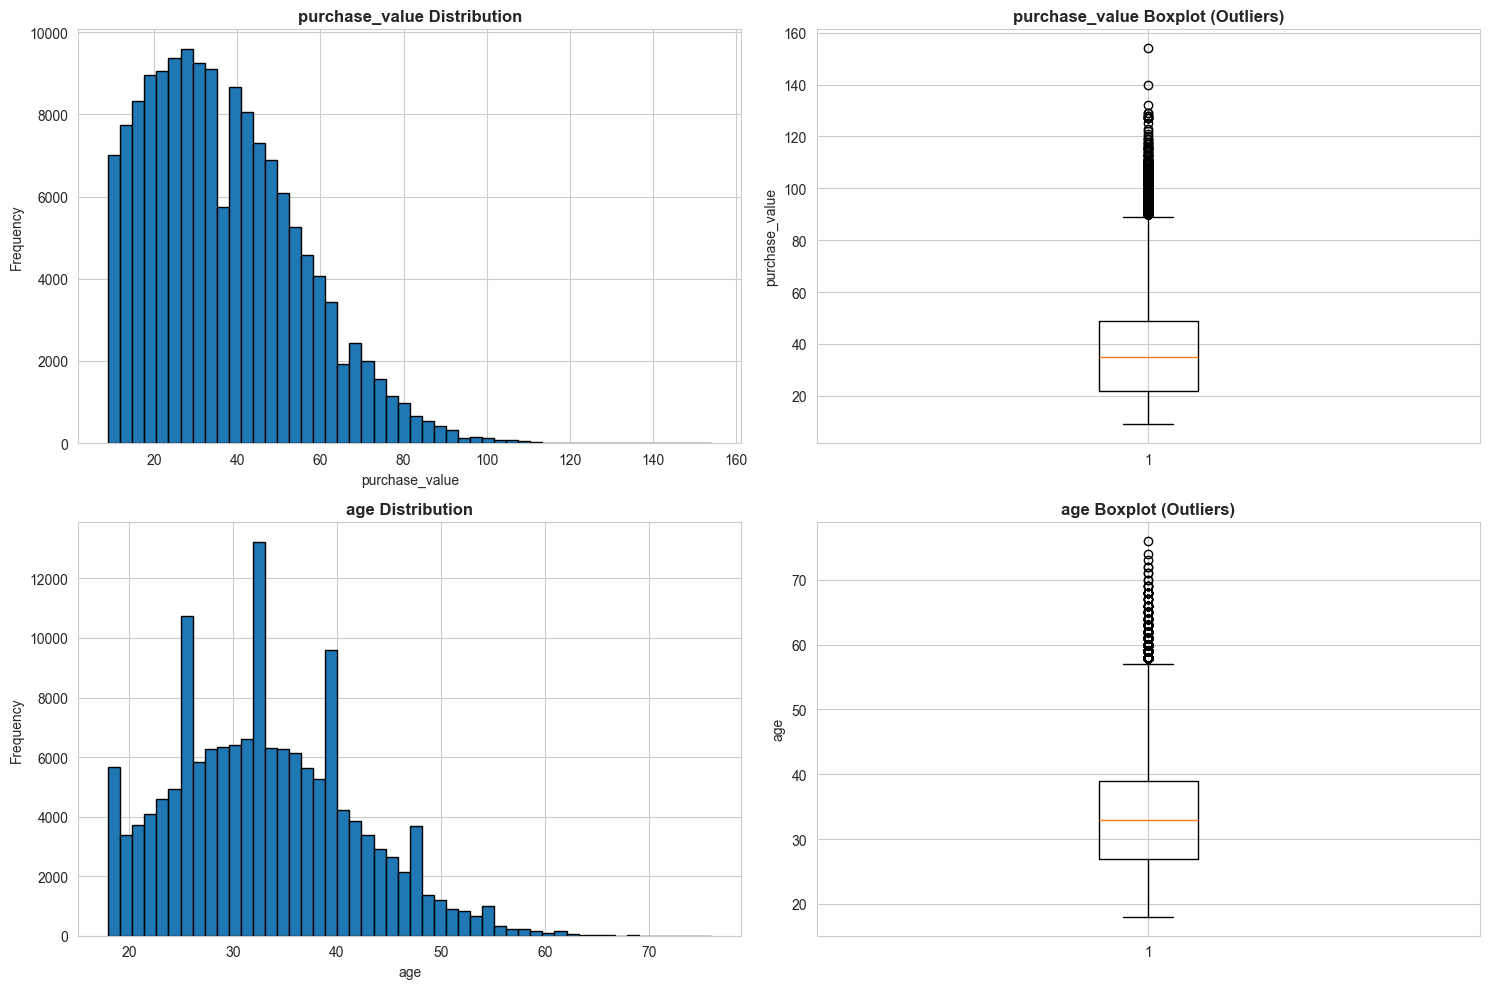


Summary Statistics:
       purchase_value            age
count   151112.000000  151112.000000
mean        36.935372      33.140704
std         18.322762       8.617733
min          9.000000      18.000000
25%         22.000000      27.000000
50%         35.000000      33.000000
75%         49.000000      39.000000
max        154.000000      76.000000


In [7]:
# Numerical features distribution
numerical_cols = ['purchase_value', 'age']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    # Histogram
    axes[idx*2].hist(fraud_df[col], bins=50, edgecolor='black')
    axes[idx*2].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[idx*2].set_xlabel(col)
    axes[idx*2].set_ylabel('Frequency')
    
    # Box plot
    axes[idx*2+1].boxplot(fraud_df[col])
    axes[idx*2+1].set_title(f'{col} Boxplot (Outliers)', fontsize=12, fontweight='bold')
    axes[idx*2+1].set_ylabel(col)

plt.tight_layout()
plt.show()

# Summary statistics
print('\nSummary Statistics:')
print(fraud_df[numerical_cols].describe())

### 3.3 Univariate Analysis - Categorical Features

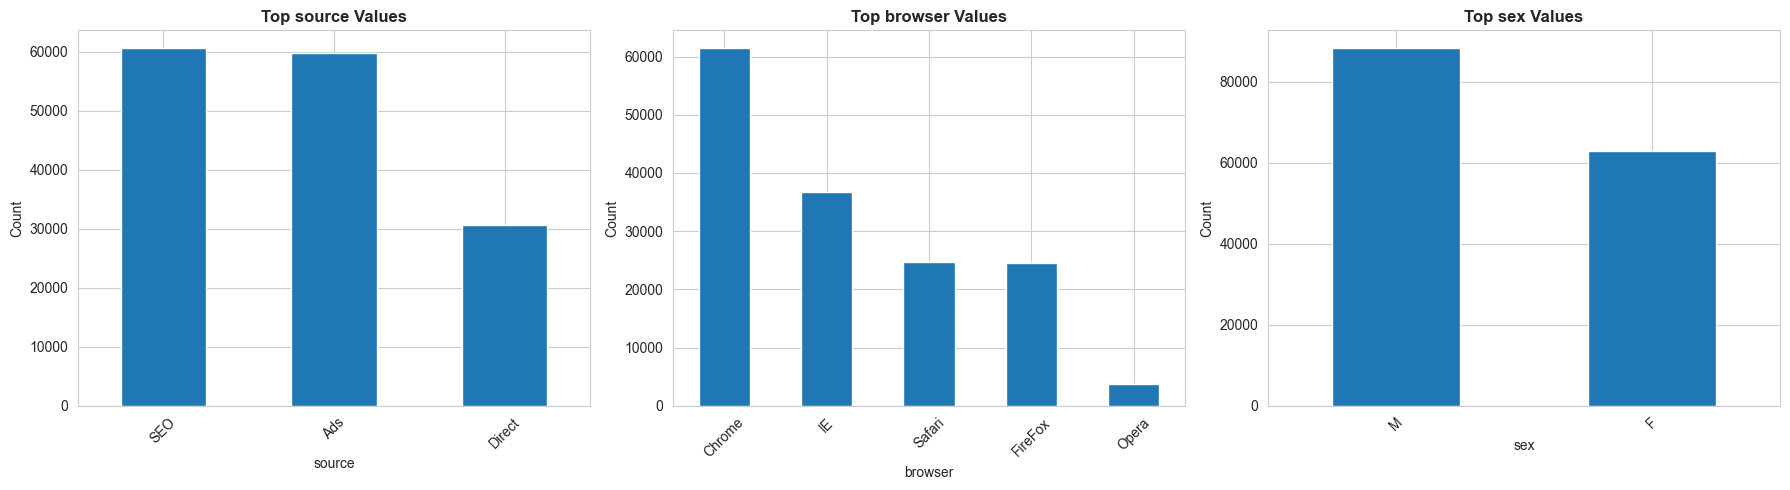

In [8]:
# Categorical features
categorical_cols = ['source', 'browser', 'sex']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(categorical_cols):
    top_values = fraud_df[col].value_counts().head(20)
    top_values.plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'Top {col} Values', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 3.4 Bivariate Analysis - Features vs Target

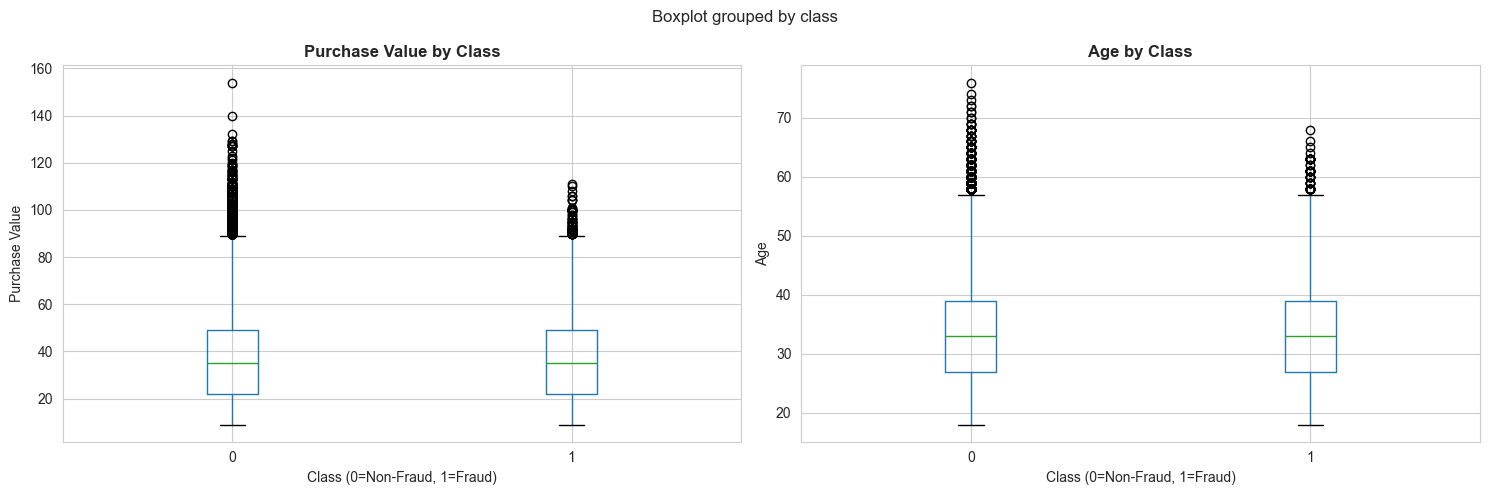

Mean Purchase Value by Class:
class
0    36.929418
1    36.993004
Name: purchase_value, dtype: float64

Mean Age by Class:
class
0    33.122356
1    33.318281
Name: age, dtype: float64


In [9]:
# Purchase value by class
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
fraud_df.boxplot(column='purchase_value', by='class', ax=axes[0])
axes[0].set_title('Purchase Value by Class', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
axes[0].set_ylabel('Purchase Value')

# Age by class
fraud_df.boxplot(column='age', by='class', ax=axes[1])
axes[1].set_title('Age by Class', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
axes[1].set_ylabel('Age')

plt.tight_layout()
plt.show()

# Statistical comparison
print('Mean Purchase Value by Class:')
print(fraud_df.groupby('class')['purchase_value'].mean())
print('\nMean Age by Class:')
print(fraud_df.groupby('class')['age'].mean())

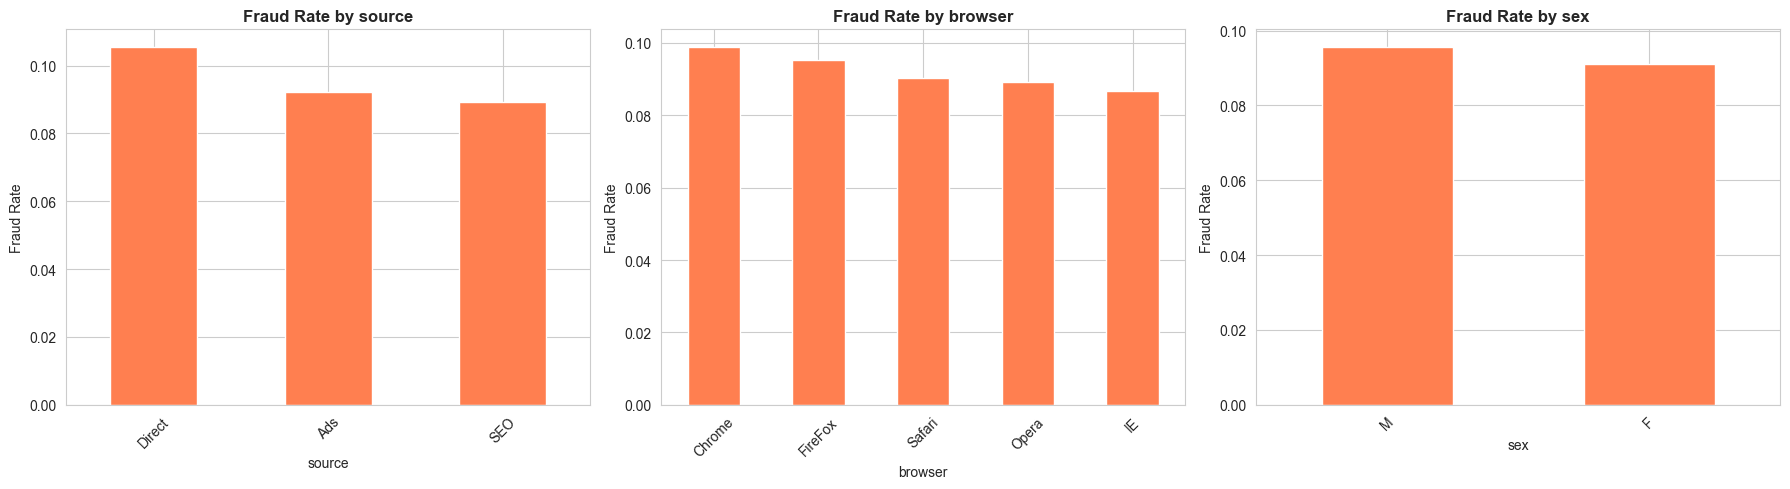

In [10]:
# Fraud rate by categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(['source', 'browser', 'sex']):
    fraud_rate = fraud_df.groupby(col)['class'].mean().sort_values(ascending=False).head(20)
    fraud_rate.plot(kind='bar', ax=axes[idx], color='coral')
    axes[idx].set_title(f'Fraud Rate by {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Fraud Rate')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Geolocation Integration

In [11]:
# IP to Country mapping
print('Mapping IP addresses to countries...')

# Sort merge approach for efficient range-based lookup
ip_country_df = ip_country_df.sort_values('lower_bound_ip_address')
fraud_df_sorted = fraud_df.sort_values('ip_address')

# Merge using merge_asof for range-based join
merged = pd.merge_asof(
    fraud_df_sorted,
    ip_country_df,
    left_on='ip_address',
    right_on='lower_bound_ip_address'
)

# Filter valid IP ranges
merged['country'] = np.where(
    merged['ip_address'] <= merged['upper_bound_ip_address'],
    merged['country'],
    'Unknown'
)

fraud_df = merged
print(f'✓ Geolocation integration complete!')
print(f'Unique countries: {fraud_df["country"].nunique()}')

Mapping IP addresses to countries...
✓ Geolocation integration complete!
Unique countries: 182


Top 10 Countries by Transaction Volume:
country
United States                      58049
Unknown                            21966
China                              12038
Japan                               7306
United Kingdom                      4490
Korea Republic of                   4162
Germany                             3646
France                              3161
Canada                              2975
Brazil                              2961
Italy                               1944
Australia                           1844
Netherlands                         1680
Russian Federation                  1616
India                               1310
Taiwan; Republic of China (ROC)     1237
Mexico                              1121
Sweden                              1090
Spain                               1027
South Africa                         838
Name: count, dtype: int64

Top 10 Countries by Fraud Count:
country
United States                      5551
Unknown                 

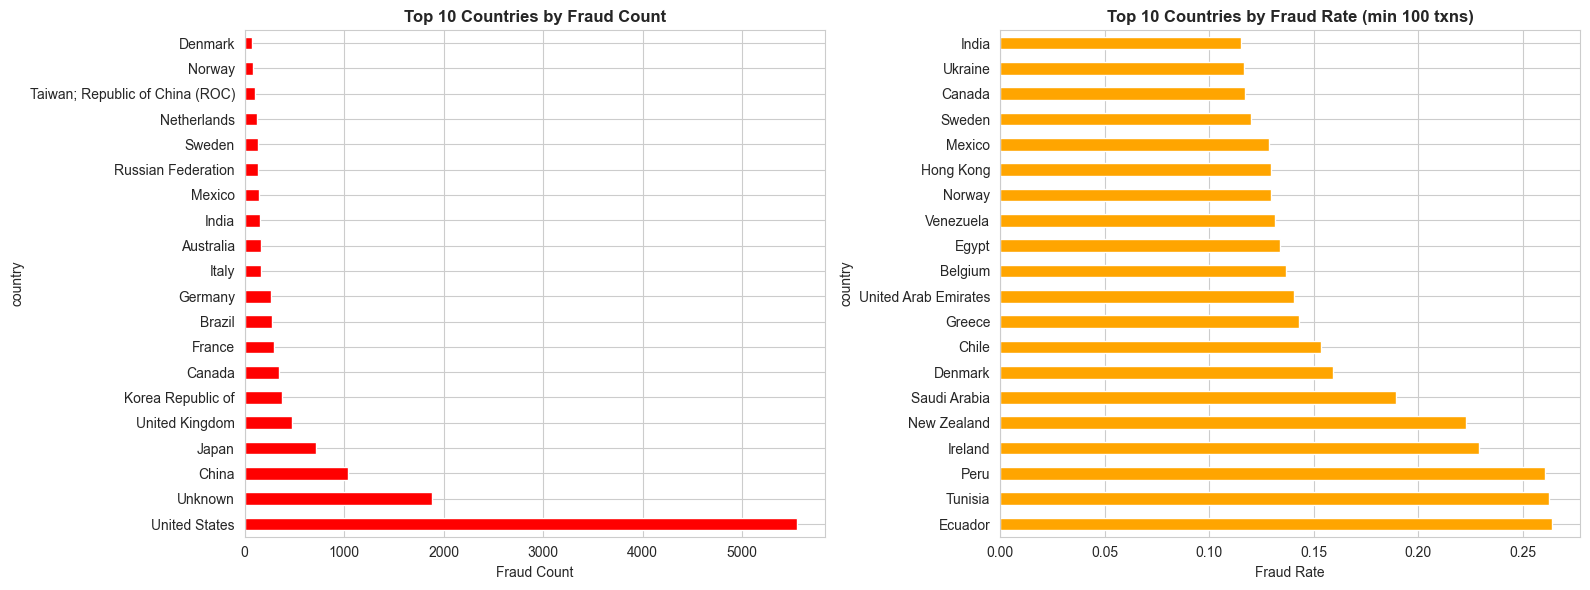

In [12]:
# Analyze fraud patterns by country
print('Top 10 Countries by Transaction Volume:')
print(fraud_df['country'].value_counts().head(20))

print('\nTop 10 Countries by Fraud Count:')
fraud_by_country = fraud_df[fraud_df['class'] == 1]['country'].value_counts().head(20)
print(fraud_by_country)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top countries by fraud count
fraud_by_country.plot(kind='barh', ax=ax1, color='red')
ax1.set_title('Top 10 Countries by Fraud Count', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fraud Count')

# Fraud rate by country
fraud_rate_country = fraud_df.groupby('country')['class'].agg(['sum', 'count'])
fraud_rate_country['fraud_rate'] = fraud_rate_country['sum'] / fraud_rate_country['count']
fraud_rate_country = fraud_rate_country[fraud_rate_country['count'] > 100]  # Min 100 transactions
top_fraud_rate = fraud_rate_country.sort_values('fraud_rate', ascending=False).head(20)

top_fraud_rate['fraud_rate'].plot(kind='barh', ax=ax2, color='orange')
ax2.set_title('Top 10 Countries by Fraud Rate (min 100 txns)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fraud Rate')

plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [13]:
print('Engineering new features...')

# Transaction frequency features
fraud_df['device_txn_count'] = fraud_df.groupby('device_id')['device_id'].transform('count')
fraud_df['ip_txn_count'] = fraud_df.groupby('ip_address')['ip_address'].transform('count')

# Time-based features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600  # hours

print('✓ Features engineered successfully!')
print('\nNew features:')
print('- device_txn_count: Transaction count per device')
print('- ip_txn_count: Transaction count per IP')
print('- hour_of_day: Hour of purchase (0-23)')
print('- day_of_week: Day of week (0=Monday, 6=Sunday)')
print('- time_since_signup: Hours between signup and purchase')

Engineering new features...
✓ Features engineered successfully!

New features:
- device_txn_count: Transaction count per device
- ip_txn_count: Transaction count per IP
- hour_of_day: Hour of purchase (0-23)
- day_of_week: Day of week (0=Monday, 6=Sunday)
- time_since_signup: Hours between signup and purchase


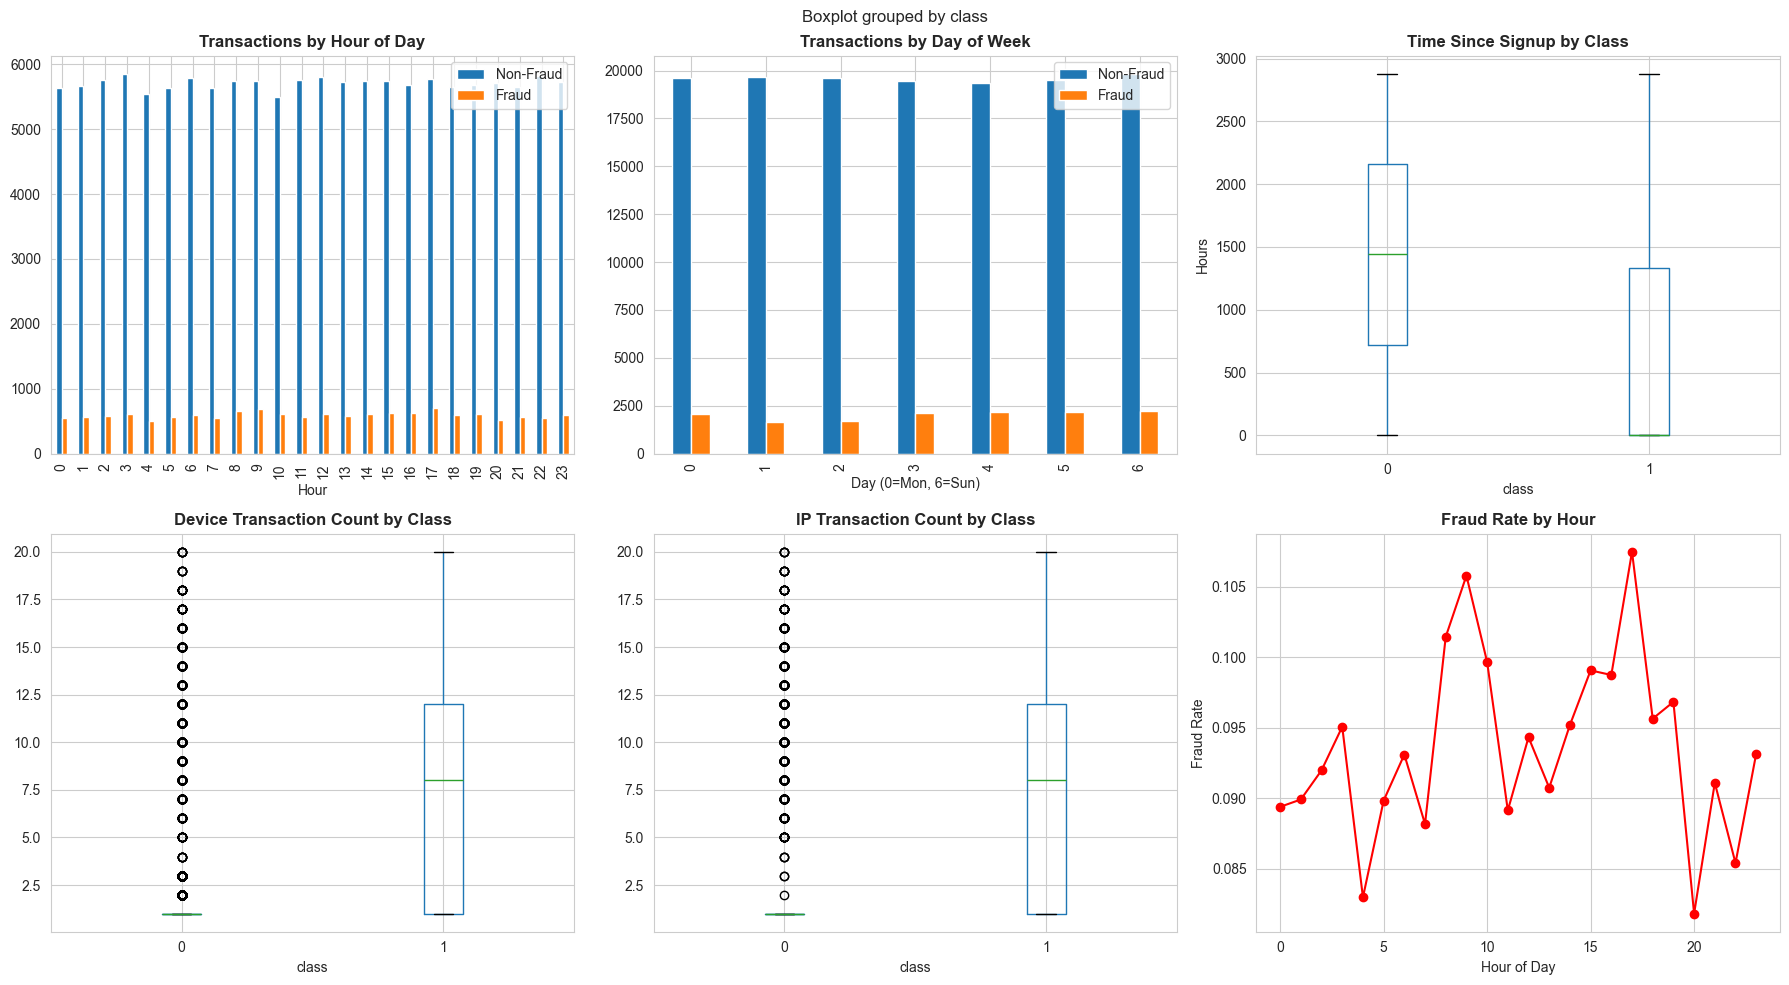

In [14]:
# Visualize engineered features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Hour of day vs fraud
fraud_df.groupby(['hour_of_day', 'class']).size().unstack().plot(kind='bar', ax=axes[0])
axes[0].set_title('Transactions by Hour of Day', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Hour')
axes[0].legend(['Non-Fraud', 'Fraud'])

# Day of week vs fraud
fraud_df.groupby(['day_of_week', 'class']).size().unstack().plot(kind='bar', ax=axes[1])
axes[1].set_title('Transactions by Day of Week', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Day (0=Mon, 6=Sun)')
axes[1].legend(['Non-Fraud', 'Fraud'])

# Time since signup distribution
fraud_df.boxplot(column='time_since_signup', by='class', ax=axes[2])
axes[2].set_title('Time Since Signup by Class', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Hours')

# Device transaction count
fraud_df.boxplot(column='device_txn_count', by='class', ax=axes[3])
axes[3].set_title('Device Transaction Count by Class', fontsize=12, fontweight='bold')

# IP transaction count
fraud_df.boxplot(column='ip_txn_count', by='class', ax=axes[4])
axes[4].set_title('IP Transaction Count by Class', fontsize=12, fontweight='bold')

# Fraud rate by hour
fraud_rate_hour = fraud_df.groupby('hour_of_day')['class'].mean()
fraud_rate_hour.plot(kind='line', marker='o', ax=axes[5], color='red')
axes[5].set_title('Fraud Rate by Hour', fontsize=12, fontweight='bold')
axes[5].set_xlabel('Hour of Day')
axes[5].set_ylabel('Fraud Rate')
axes[5].grid(True)

plt.tight_layout()
plt.show()

## 6. Data Transformation

In [15]:
# Prepare data for transformation
drop_cols = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address',
             'lower_bound_ip_address', 'upper_bound_ip_address']

# Drop columns that resulted from merge or are not needed
cols_to_drop = [c for c in drop_cols if c in fraud_df.columns]

# Separate target and features
y = fraud_df['class']
X = fraud_df.drop(columns=['class'] + cols_to_drop)

print('Features for modeling:')
print(X.columns.tolist())
print(f'\nShape: {X.shape}')

Features for modeling:
['purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'device_txn_count', 'ip_txn_count', 'hour_of_day', 'day_of_week', 'time_since_signup']

Shape: (151112, 11)


In [16]:
# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

print(f'Categorical columns ({len(cat_cols)}): {cat_cols}')
print(f'Numerical columns ({len(num_cols)}): {num_cols}')

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# Transform data
X_processed = preprocessor.fit_transform(X)

print(f'\n✓ Data transformed successfully!')
print(f'Original shape: {X.shape}')
print(f'Transformed shape: {X_processed.shape}')
print(f'Features increased from {X.shape[1]} to {X_processed.shape[1]} (due to one-hot encoding)')

Categorical columns (4): ['source', 'browser', 'sex', 'country']
Numerical columns (7): ['purchase_value', 'age', 'device_txn_count', 'ip_txn_count', 'hour_of_day', 'day_of_week', 'time_since_signup']

✓ Data transformed successfully!
Original shape: (151112, 11)
Transformed shape: (151112, 199)
Features increased from 11 to 199 (due to one-hot encoding)


## 7. Handle Class Imbalance with SMOTE

### 7.1 Justification for SMOTE

**Why SMOTE over Undersampling?**

1. **Data Preservation**: With 151K+ transactions and only ~9% fraud, undersampling would discard valuable non-fraud data
2. **Better Generalization**: SMOTE creates synthetic samples in feature space, helping model learn decision boundaries
3. **Imbalance Ratio**: With ~10:1 imbalance, oversampling minority class is more effective than losing majority data
4. **Model Performance**: SMOTE typically yields better recall and F1-score for fraud detection

**SMOTE Algorithm**:
- Generates synthetic samples by interpolating between existing minority class samples
- Uses k-nearest neighbors to create realistic fraud transactions
- Maintains data distribution while balancing classes

In [17]:
# Document class distribution BEFORE resampling
print('Class Distribution BEFORE SMOTE:')
print('='*50)
original_dist = Counter(y)
print(f'Non-Fraud (0): {original_dist[0]:,}')
print(f'Fraud (1): {original_dist[1]:,}')
print(f'Imbalance Ratio: {original_dist[0]/original_dist[1]:.1f}:1')
print(f'Fraud %: {(original_dist[1]/len(y))*100:.2f}%')

Class Distribution BEFORE SMOTE:
Non-Fraud (0): 136,961
Fraud (1): 14,151
Imbalance Ratio: 9.7:1
Fraud %: 9.36%


In [18]:
# Apply SMOTE
print('\nApplying SMOTE...')
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

# Document class distribution AFTER resampling
print('\nClass Distribution AFTER SMOTE:')
print('='*50)
resampled_dist = Counter(y_resampled)
print(f'Non-Fraud (0): {resampled_dist[0]:,}')
print(f'Fraud (1): {resampled_dist[1]:,}')
print(f'Imbalance Ratio: {resampled_dist[0]/resampled_dist[1]:.1f}:1')
print(f'Fraud %: {(resampled_dist[1]/len(y_resampled))*100:.2f}%')

print('\n✓ SMOTE completed successfully!')
print(f'Synthetic fraud samples created: {resampled_dist[1] - original_dist[1]:,}')


Applying SMOTE...

Class Distribution AFTER SMOTE:
Non-Fraud (0): 136,961
Fraud (1): 136,961
Imbalance Ratio: 1.0:1
Fraud %: 50.00%

✓ SMOTE completed successfully!
Synthetic fraud samples created: 122,810


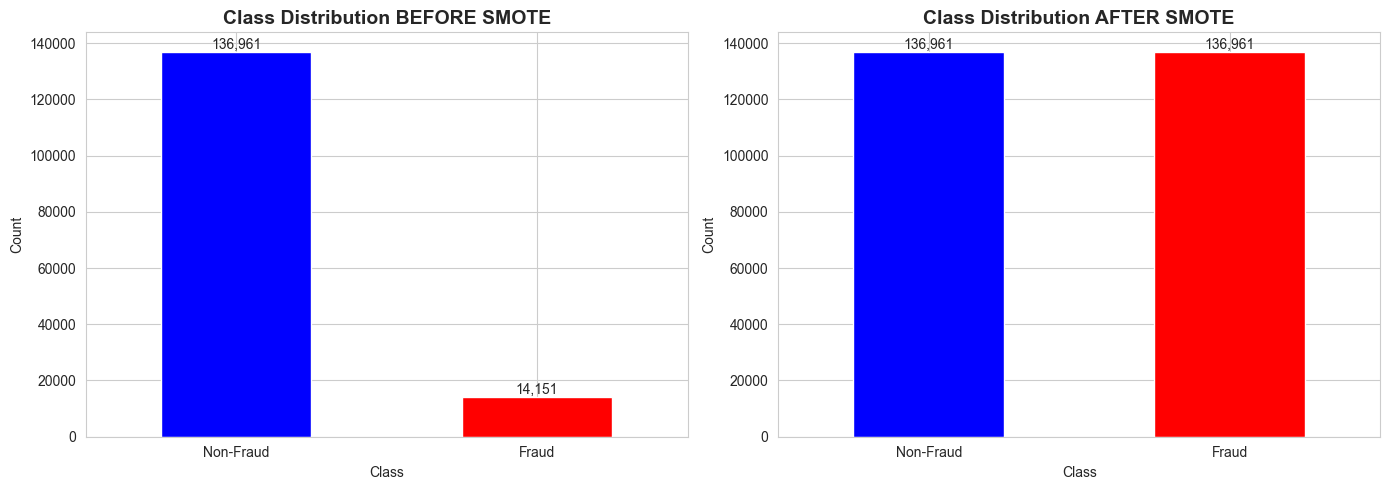

In [19]:
# Visualize before/after SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
pd.Series(y).value_counts().plot(kind='bar', ax=ax1, color=['blue', 'red'])
ax1.set_title('Class Distribution BEFORE SMOTE', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

# After SMOTE
pd.Series(y_resampled).value_counts().plot(kind='bar', ax=ax2, color=['blue', 'red'])
ax2.set_title('Class Distribution AFTER SMOTE', fontsize=14, fontweight='bold')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Save Processed Data

In [20]:
# Save resampled data
import os
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Save as numpy arrays
np.save(f'{PROCESSED_DIR}/X_resampled.npy', X_resampled)
np.save(f'{PROCESSED_DIR}/y_resampled.npy', y_resampled)

# Save feature names
feature_names = num_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
with open(f'{PROCESSED_DIR}/feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_names))

print('✓ Processed data saved to:', PROCESSED_DIR)
print(f'- X_resampled.npy: {X_resampled.shape}')
print(f'- y_resampled.npy: {y_resampled.shape}')
print(f'- feature_names.txt: {len(feature_names)} features')

✓ Processed data saved to: ../data/processed
- X_resampled.npy: (273922, 199)
- y_resampled.npy: (273922,)
- feature_names.txt: 199 features


## Summary

### Task 1 Completion Checklist:

✅ **Data Cleaning**
- Missing value analysis completed
- Duplicates removed
- Data types corrected

✅ **Exploratory Data Analysis**
- Univariate analysis with distributions
- Bivariate analysis with target relationships
- Class distribution quantified

✅ **Geolocation Integration**
- IP addresses converted to integer format
- Merged with IP-Country data
- Fraud patterns analyzed by country

✅ **Feature Engineering**
- Transaction frequency features
- Time-based features (hour, day, time_since_signup)
- All required features implemented

✅ **Data Transformation**
- StandardScaler for numerical features
- OneHotEncoder for categorical features
- Proper preprocessing pipeline

✅ **Class Imbalance Handling**
- SMOTE applied with justification
- Distribution documented before/after
- Ready for modeling

### Next Steps:
- Task 2: Model training and evaluation
- Task 3: Model comparison and selection
- Task 4: Deployment preparation